In [2]:
from keras.datasets import mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from NN_handcraft import NN_model,One_layer,shuffle
import seaborn as sns
from sklearn import svm
sns.set_theme(style="whitegrid")

In [3]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
x_train = X_train.reshape(60000,28, 28,1)/255
x_test = X_test.reshape(10000, 28, 28,1)/255
x_train = x_train.reshape(60000,-1)
x_test = x_test.reshape(10000,-1)
y_train = pd.get_dummies(Y_train).to_numpy()
y_test = pd.get_dummies(Y_test).to_numpy()
x_train = x_train.T
x_test = x_test.T
y_train = y_train.T
y_test = y_test.T
x_train,y_train = shuffle(x_train,y_train)
split_ratio = 0.9
index_to_split = int(x_train.shape[1]*split_ratio)
x_tr = x_train[:,:index_to_split]
x_va = x_train[:,index_to_split:]
y_tr = y_train[:,:index_to_split]
y_tr_SVM = Y_train[:index_to_split]
y_va = y_train[:,index_to_split:]
y_va_SVM = Y_train[index_to_split:]

In [4]:
class Conv_layer:
    def __init__(self, in_dim, filters, kernel_size, act, lr):
        self.in_dim = in_dim[0]*in_dim[1]*in_dim[2] 
        out = np.array([filters, in_dim[1] - kernel_size[0] + 1, in_dim[1] - kernel_size[0] + 1]) 
        self.out_dim = out[0]*out[1]*out[2]
        weight = np.array([])
        self.weight = np.array([])
        self.filter_weight = np.random.randn(filters, kernel_size[0], kernel_size[0])/10
        a = 0
        b = 0
        for i in range(filters):
            temp = np.array([])
            for size in range(kernel_size[0]):
                temp = np.concatenate((temp,self.filter_weight[i,size,:],np.zeros(in_dim[2] - kernel_size[0])),axis = 0)        
            temp = np.concatenate((temp,np.zeros((in_dim[1] - kernel_size[0])*in_dim[2])),axis = 0) #一排weight 完成
            
            for row in range(out[1]):
                for col in range(out[2]):
                    
                    weight_temp = np.array([])
                    weight_temp = np.concatenate((np.zeros(col+row*out[2]),temp),axis = 0)
                    weight_temp = np.delete(weight_temp, np.arange(out[1]*out[2],out[1]*out[2]+col+row*out[2]), axis = 0)
                    weight_temp = weight_temp.reshape(1,-1)
                    
                    if col == 0 and row == 0 and i == 0:
                        weight = weight_temp          
                    else:
                        weight = np.concatenate((weight, weight_temp), axis = 0)
        for i in range(in_dim[0]):
            if i == 0:
                self.weight = weight
            else:
                self.weight = np.concatenate((self.weight, weight), axis = 1)
                
        
        act_list = {"relu":self.sigmoid, "tanh":self.tanh,"relu":self.relu,"sigmoid":self.sigmoid,
                    "softmax":self.softmax,"linear":self.linear}
        dif_list = {"relu":self.dif_sigmoid, "tanh":self.dif_tanh,"relu":self.dif_relu,"sigmoid":self.dif_sigmoid,
                    "softmax":self.dif_softmax,"linear":self.dif_linear}
        self.act = act_list[act]
        self.dif_act = dif_list[act]
        self.lr = lr
        #self.batch_size = batch_size
        self.input = np.array([]) #np.zeros((batch_size,in_dim))
        self.local_grad = np.array([]) #np.zeros((batch_size,out_dim))    
        self.value = np.array([])
        
    def forward(self,data):    
        self.input = data
        self.value = self.weight.dot(data)
        return self.act(self.value) 
    
    def output(self,data): 
        return self.act(self.weight.dot(data))    
    
    def backward(self,err):
        self.local_grad = self.dif_act(self.value,err)
        return self.weight.T.dot(self.local_grad)[:,:]    
    
    def weight_renew(self,batch_size):       
        delta_w = self.lr*(self.local_grad).dot(self.input.T)#/batch_size#
        self.weight = self.weight - delta_w
            
    def sigmoid(self,z):
        return 1/(1+np.exp(-z))
    def tanh(self,z):
        return (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))
    def relu(self,z):
        return np.maximum(0,z)  
    
    def linear(self,z):
        return z 
    
    def dif_linear(self,z,err):
        return err
    
    def softmax(self,x):
        shiftx = x - np.max(x)
        exps = np.exp(shiftx)
        return exps / np.sum(exps,axis=0)    
    
    def dif_sigmoid(self,z,err):
        temp=self.sigmoid(z)        
        return (temp*(1-temp))*err    
    def dif_tanh(self,z,err):
        return (1-self.tanh(self,z)**2)*err    
    def dif_relu(self,z,err):
        return np.maximum(np.sign(z),0)*err     
    def dif_softmax(self,z,err):
        local_grad = []
        for i,ee in enumerate(z.T):
            ee = ee.T.reshape(1,-1)
            tt = self.softmax(ee.T)
            local_grad.append((np.eye(ee.size)*tt-tt.dot(tt.T)).dot(err[:,i]))
        return np.array(local_grad).T#(np.eye(self.out_dim)*S - S.dot(S.T)).dot(err)
    def fetch_w(self):
        return self.weight

In [5]:
class max_pooling:
    def __init__(self, in_dim, size):
        self.shapes = in_dim
        self.size = size
        self.out_dim = np.uint16(in_dim[1]/size*in_dim[2]/size)*in_dim[0]
        self.input = np.array([]) #np.zeros((batch_size,in_dim))
        self.local_grad = np.array([]) #np.zeros((batch_size,out_dim))    
        self.value = np.array([])
        self.index = np.array([])
        
    def forward(self,data):
        self.input = data
        feature_map = data.reshape(data.shape[1],self.shapes[0],self.shapes[1],self.shapes[2])
        pool_out = np.zeros((feature_map.shape[0],feature_map.shape[1],int(self.shapes[1]/self.size),
                             int(self.shapes[2]/self.size)))
        self.index = np.zeros((data.shape[1],self.shapes[0],self.shapes[1],self.shapes[2]))
        for batch in range(feature_map.shape[0]):
            for map_num in range(feature_map.shape[1]):
                r2 = 0
                for r in np.arange(0,int(self.shapes[1]/self.size), self.size):
                    c2 = 0
                    for c in np.arange(0, int(self.shapes[2]/self.size), self.size):
                        pool_out[batch, map_num, r2, c2] = np.max([feature_map[batch, map_num, r:r+self.size,  c:c+self.size]])
                        index = np.argmax([feature_map[batch, map_num, r:r+self.size,  c:c+self.size]])
                        self.index[batch, map_num, r+int(index//self.size), c+int(index%self.size)] = 1
                        c2 = c2 + 1
                    r2 = r2 +1
        self.value = pool_out.reshape(-1,data.shape[1])
#         print("forward ok")
        return self.value
    
    def backward(self,err):
        data = err.reshape(err.shape[1],self.shapes[0],int(self.shapes[1]/self.size),int(self.shapes[2]/self.size))
        for batch in range(data.shape[0]):
            for map_num in range(data.shape[1]):
                r2 = 0
                for r in np.arange(0,int(self.shapes[1]/self.size), self.size):
                    c2 = 0
                    for c in np.arange(0, int(self.shapes[2]/self.size), self.size):
                        index = np.argmax([self.index[batch, map_num, r:r+self.size,  c:c+self.size]])
                        self.index[batch, map_num, r+int(index/self.size), c+int(index%self.size)] = data[batch, map_num, r2, c2]
                        c2 = c2 + 1
                    r2 = r2 +1
#         print("backward ok")
        return self.index.reshape(-1,err.shape[1])
    
    def output(self,data): 
        self.input = data
        feature_map = data.reshape(data.shape[1],self.shapes[0],self.shapes[1],self.shapes[2])
        pool_out = np.zeros((feature_map.shape[0],feature_map.shape[1],int(self.shapes[1]/self.size),
                            int(self.shapes[2]/self.size)))
        for batch in range(feature_map.shape[0]):
            for map_num in range(feature_map.shape[1]):
                r2 = 0
                for r in np.arange(0,int(self.shapes[1]/self.size), self.size):
                    c2 = 0
                    for c in np.arange(0, int(self.shapes[2]/self.size), self.size):
                        pool_out[batch, map_num, r2, c2] = np.max([feature_map[batch, map_num, r:r+self.size,  c:c+self.size]])
                        c2 = c2 + 1
                    r2 = r2 +1
        return pool_out.reshape(-1,data.shape[1])

    def weight_renew(self,batch_size):       
        a = 0

In [ ]:
#CNN + NN
hh=[]
rate = 5
ww= []
SVM_val = []
SVM_train = []
for ll in range(1):
    lrr = 0.001*(1+ll)
    print(lrr)
    model1 = NN_model([
        Conv_layer(np.array([1,28,28]), 6, np.array([5,5]), "sigmoid", lr=lrr), 
#         max_pooling(np.array([6,24,24]),2),
        Conv_layer(np.array([6,24,24]), 12, np.array([5,5]), "sigmoid", lr=lrr), 
#         max_pooling(np.array([12,8,8]),2),
        One_layer(in_dim=4800,out_dim=10,act="softmax",lr=lrr)],
        batch_size = 256,loss='Multi_class'
    )
    history = model1.training(x_tr,x_va,y_tr,y_va,epochs=20)
    hh.append(history)
    

0.001
Epoch 0 / 20 - loss: 5.9817 - accuracy: 0.0976 - val_loss: 5.9717 - val_accuracy: 0.0950
Epoch 1 / 20 - loss: 3.4363 - accuracy: 0.1004 - val_loss: 3.4210 - val_accuracy: 0.1063
Epoch 2 / 20 - loss: 2.7959 - accuracy: 0.3643 - val_loss: 2.7900 - val_accuracy: 0.3660
Epoch 3 / 20 - loss: 1.4619 - accuracy: 0.5637 - val_loss: 1.5130 - val_accuracy: 0.5557
Epoch 4 / 20 - loss: 0.8605 - accuracy: 0.7178 - val_loss: 0.8931 - val_accuracy: 0.7053
Epoch 5 / 20 - loss: 0.4532 - accuracy: 0.8611 - val_loss: 0.5092 - val_accuracy: 0.8478
Epoch 6 / 20 - loss: 0.4776 - accuracy: 0.8554 - val_loss: 0.5239 - val_accuracy: 0.8448
Epoch 7 / 20 - loss: 0.4877 - accuracy: 0.8397 - val_loss: 0.5430 - val_accuracy: 0.8255
Epoch 8 / 20 - loss: 0.3363 - accuracy: 0.8987 - val_loss: 0.3894 - val_accuracy: 0.8850
Epoch 9 / 20 - loss: 0.3465 - accuracy: 0.8949 - val_loss: 0.3965 - val_accuracy: 0.8807
Epoch 10 / 20 - loss: 0.3177 - accuracy: 0.9070 - val_loss: 0.3710 - val_accuracy: 0.8955
Epoch 11 / 20 

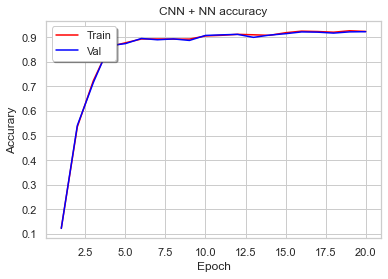

In [22]:
# CNN + NN accuracy
x = []
for i in range(20):
    x.append(i+1)
y_train = hh[0][:,2]
y_val = hh[0][:,3]
plt.title("CNN + NN accuracy") 
plt.xlabel("Epoch") 
plt.ylabel("Accurary")
plt.plot(x,y_train,'-',color='red',label='Train')
plt.plot(x,y_val,'-',color='blue',label='Val')
plt.legend(loc='upper left', shadow=True)

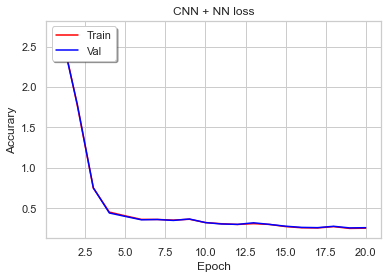

In [23]:
# CNN + NN loss
x = []
for i in range(20):
    x.append(i+1)
y_train = hh[0][:,0]
y_val = hh[0][:,1]
plt.title("CNN + NN loss") 
plt.xlabel("Epoch") 
plt.ylabel("Loss")
plt.plot(x,y_train,'-',color='red',label='Train')
plt.plot(x,y_val,'-',color='blue',label='Val')
plt.legend(loc='upper left', shadow=True)

In [6]:
#CNN + NN
hh=[]
rate = 5
ww= []
SVM_val = []
SVM_train = []
for ll in range(1):
    lrr = 0.1*(1+ll)
    print(lrr)
    model1 = NN_model([
        Conv_layer(np.array([1,28,28]), 6, np.array([5,5]), "sigmoid", lr=lrr), 
        max_pooling(np.array([6,24,24]),2),
        Conv_layer(np.array([6,12,12]), 12, np.array([5,5]), "sigmoid", lr=lrr), 
        max_pooling(np.array([12,8,8]),2),
        One_layer(in_dim=192,out_dim=10,act="softmax",lr=lrr)],
        batch_size = 256,loss='Multi_class'
    )
    history = model1.training(x_tr,x_va,y_tr,y_va,epochs=20)
    hh.append(history)
    

0.1
Epoch 0 / 20 - loss: 15.6127 - accuracy: 0.0970 - val_loss: 13.4548 - val_accuracy: 0.0968
Epoch 1 / 20 - loss: 15.6892 - accuracy: 0.0946 - val_loss: 13.6463 - val_accuracy: 0.0982
Epoch 2 / 20 - loss: 15.9657 - accuracy: 0.0963 - val_loss: 13.6580 - val_accuracy: 0.0920
Epoch 3 / 20 - loss: 14.9727 - accuracy: 0.1081 - val_loss: 12.8044 - val_accuracy: 0.1035
Epoch 4 / 20 - loss: 14.9468 - accuracy: 0.0981 - val_loss: 12.8724 - val_accuracy: 0.0977
Epoch 5 / 20 - loss: 15.2071 - accuracy: 0.0960 - val_loss: 13.0130 - val_accuracy: 0.1002
Epoch 6 / 20 - loss: 14.7493 - accuracy: 0.0949 - val_loss: 12.7346 - val_accuracy: 0.0982
Epoch 7 / 20 - loss: 15.5872 - accuracy: 0.0998 - val_loss: 12.9718 - val_accuracy: 0.0967
Epoch 8 / 20 - loss: 15.1733 - accuracy: 0.0963 - val_loss: 13.0127 - val_accuracy: 0.0920
Epoch 9 / 20 - loss: 15.4987 - accuracy: 0.0994 - val_loss: 13.1748 - val_accuracy: 0.0967
Epoch 10 / 20 - loss: 16.1090 - accuracy: 0.0961 - val_loss: 13.8856 - val_accuracy: 0

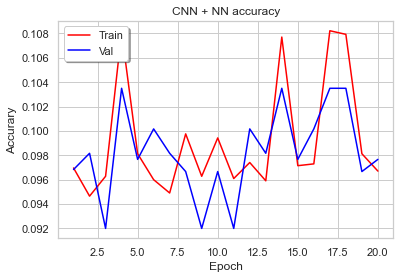

In [7]:
# CNN + NN accuracy
x = []
for i in range(20):
    x.append(i+1)
y_train = hh[0][:,2]
y_val = hh[0][:,3]
plt.title("CNN + NN accuracy") 
plt.xlabel("Epoch") 
plt.ylabel("Accurary")
plt.plot(x,y_train,'-',color='red',label='Train')
plt.plot(x,y_val,'-',color='blue',label='Val')
plt.legend(loc='upper left', shadow=True)

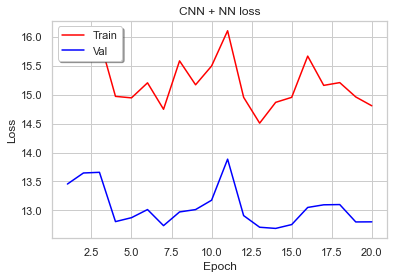

In [10]:
# CNN + NN loss
x = []
for i in range(20):
    x.append(i+1)
y_train = hh[0][:,0]
y_val = hh[0][:,1]
plt.title("CNN + NN loss") 
plt.xlabel("Epoch") 
plt.ylabel("Loss")
plt.plot(x,y_train,'-',color='red',label='Train')
plt.plot(x,y_val,'-',color='blue',label='Val')
plt.legend(loc='upper left', shadow=True)